### Gathering Insights from airbnb city data for Seattle using Data science and Machine Learning

#### 1. How does the average daily listing price trend with day of year in Seattle in 2016?
#### 2. What features most closely relate to listing prices?
#### 3. How can we predict listing prices provided other features?


#### Get the required packages

In [1]:
#The anaconda environment used here comes with python 3.6 and all the necessary packages installed (listed below)

import os
from functions import *

#Data retrival and handling packages
import pandas as pd
import numpy as np

#Data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm

#Get scikit learn tools for machine learning
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style='ticks')

C:\Users\samee\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ModuleNotFoundError: No module named 'sklearn.impute'

#### Fetch airbnb city data from the local repository


In [2]:
#get calendar and listings data
calendar = get_airbnb_data('seattle', 'calendar')
listings = get_airbnb_data('seattle', 'listings')

calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### Format Calendar data 



In [4]:
#Convert date to pandas datetime format
calendar['date'] = to_date_time(calendar.date)

#Convert price to type float
calendar['price'] = to_numeric(calendar.price)

calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### Visualize pricing trends in relation to time of year

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


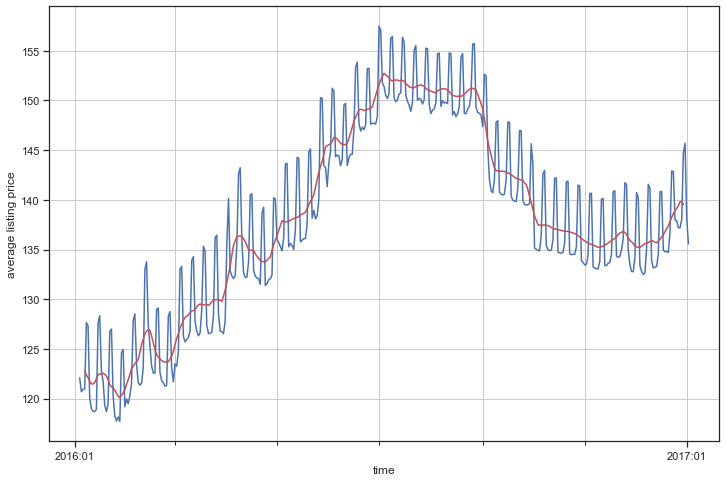

In [5]:
#for each date, calculate mean price over all available property listings
df = pd.DataFrame(calendar.groupby('date')['price'].mean())

#decompose observed time series into its 3 components: trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(df, model='additive')    #price = Level + Trend + Seasonality + Noise

#plot oberved time series of property prices
plot_time_series(df.index, df.price)

#plot price trend
plt.plot(decomposition.trend.index, decomposition.trend, "-r")

plt.show()

#### Clean and format listings data

In [6]:
num_cols = ['host_listings_count','latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds', 'price','number_of_reviews',
            'review_scores_rating','reviews_per_month']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable']

listings = listings[num_cols+cat_cols]

#get pricing data from the calendar dataset
listings['price'] = calendar.groupby('listing_id', sort=False, as_index=False)['price'].mean().drop('listing_id', axis=1)

listings.head()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,reviews_per_month,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,instant_bookable
0,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,85.000000,207,95.0,4.07,within a few hours,f,t,Queen Anne,Apartment,Entire home/apt,f
1,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,170.931271,43,96.0,1.48,within an hour,t,t,Queen Anne,Apartment,Entire home/apt,f
2,2.0,47.629724,-122.369483,11,4.5,5.0,7.0,1301.818182,20,97.0,1.15,within a few hours,f,t,Queen Anne,House,Entire home/apt,f
3,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,100.000000,0,NaN,NaN,NaN,f,t,Queen Anne,Apartment,Entire home/apt,f
4,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,462.739726,38,92.0,0.89,within an hour,f,t,Queen Anne,House,Entire home/apt,f


#### Visualize feature correlations

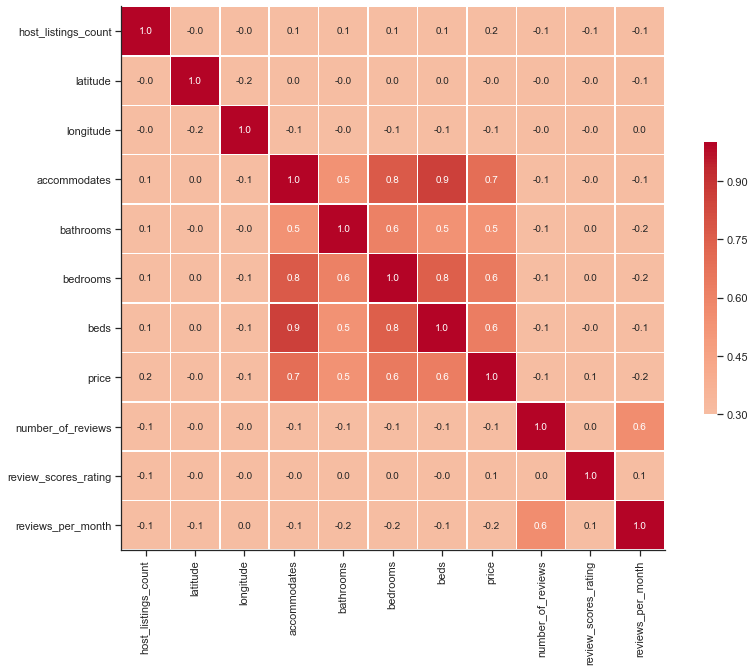

In [7]:
corr = listings.corr()
g = sns.heatmap(corr, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(14,10)

plt.show()

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


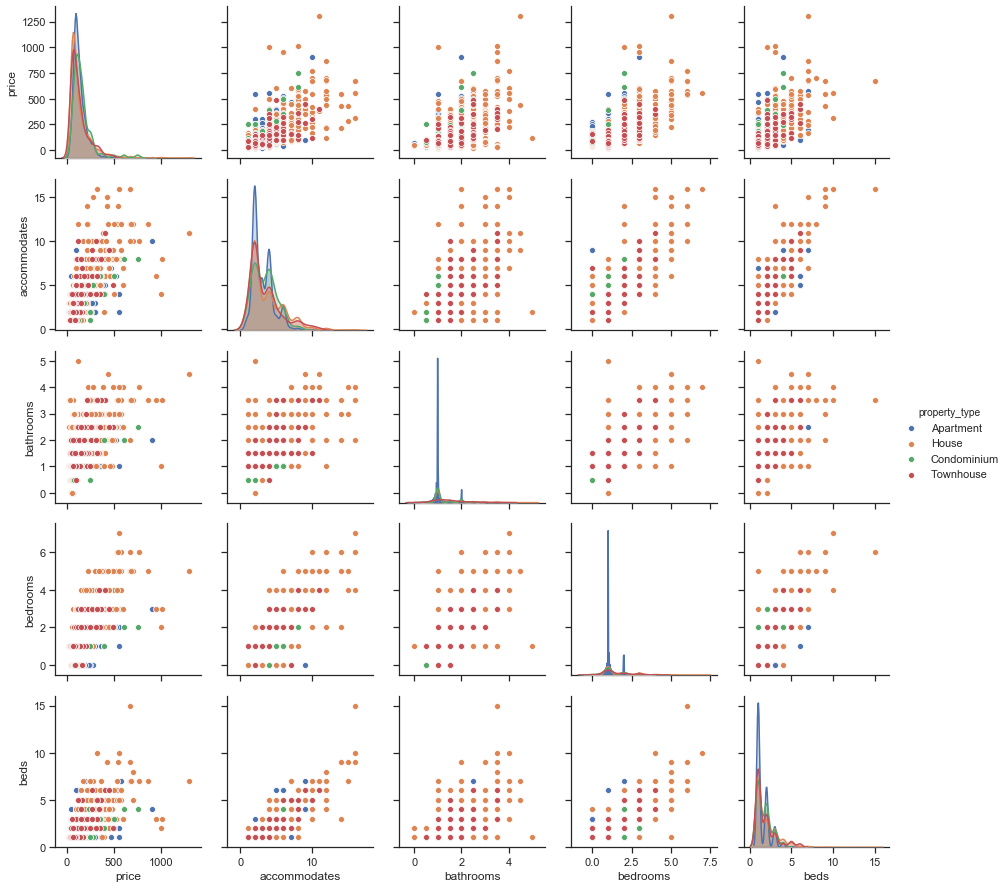

<Figure size 864x720 with 0 Axes>

In [8]:
filtered_listings = listings[listings['property_type'].isin(['House', 'Apartment', 'Condominium', 'Townhouse'])].copy()

g = sns.pairplot(filtered_listings[['price', 'accommodates', 'bathrooms',
                           'bedrooms', 'beds', 'property_type']], hue='property_type')
sns.despine()
plt.figure(figsize=(12,10))
plt.show()

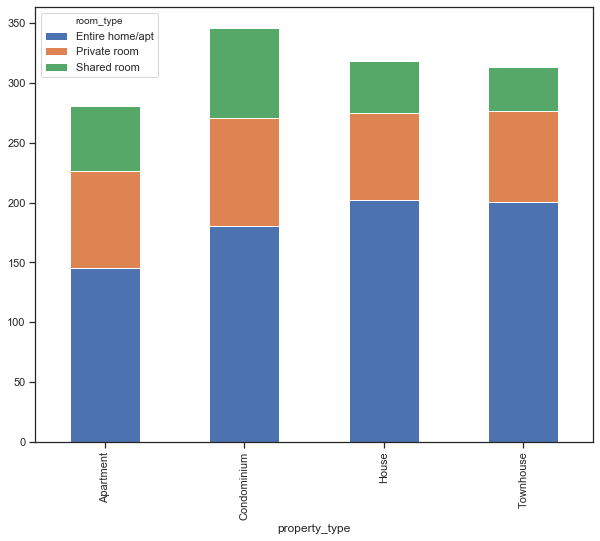

In [9]:
df = filtered_listings.groupby(['property_type', 'room_type'])['price'].mean().unstack()
df.plot.bar(stacked=True, figsize=(10,8))
plt.show()

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


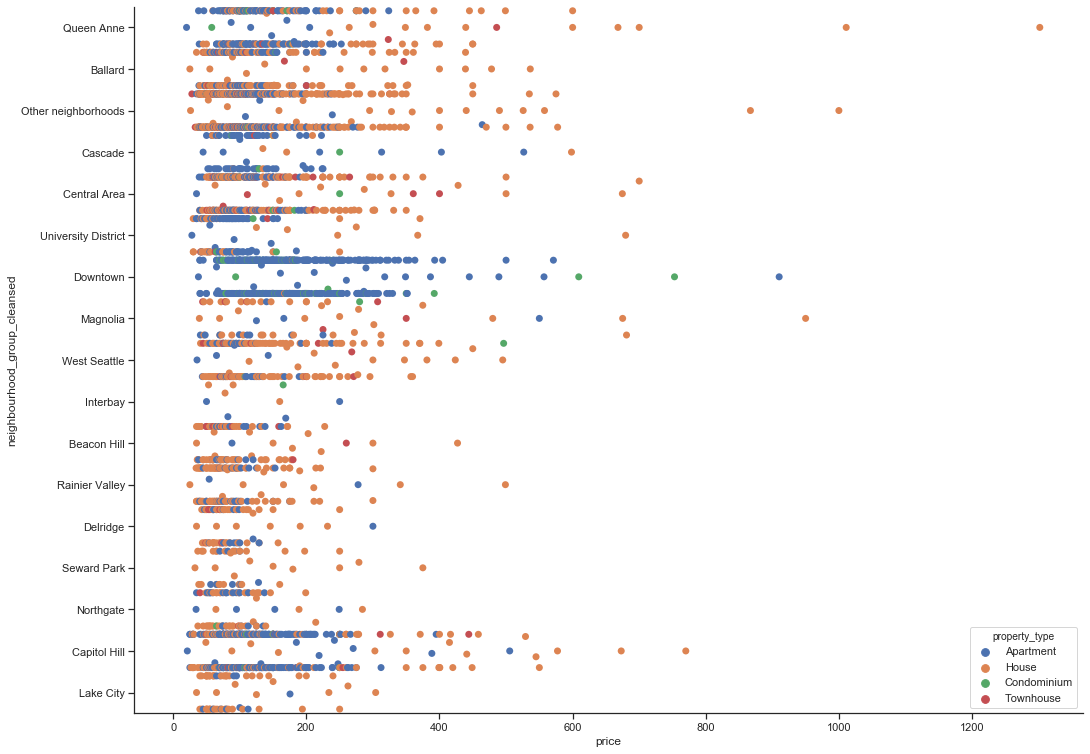

In [10]:
g = sns.swarmplot(y='neighbourhood_group_cleansed',
                 x='price',
                  hue='property_type',
                 data=filtered_listings,
                 size=7)
sns.despine()
g.figure.set_size_inches(17,13)
plt.show()

#### Visualize property price variation in relation to location


c:\code\Udacity\airbnb\functions.py:83: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  llcrnrlon=lon_0-0.05, urcrnrlon=lon_1+0.05)
c:\code\Udacity\airbnb\functions.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1)
c:\code\Udacity\airbnb\functions.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcounties(color='red', linewidth=1)


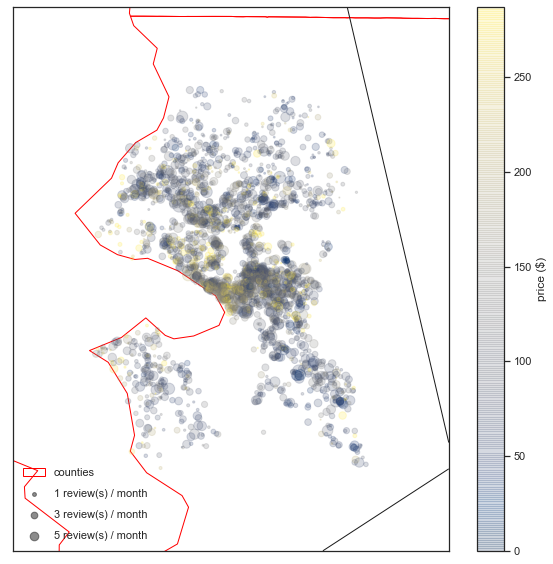

In [11]:
df = listings[['latitude', 'longitude', 'price', 'reviews_per_month']].copy()

#clean df 
df.dropna(axis=0, inplace=True)

latitudes = df.latitude
longitudes = df.longitude
price_distribution = df.price
activity_distribution = df.reviews_per_month

plot_geographical(latitudes, longitudes, price_distribution, activity_distribution)

#### Prepare data for machine learning pipelines


In [12]:
listings_ml = listings.dropna(subset=['price'], axis=0)

X = listings_ml.drop('price', axis=1)
y = listings_ml['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

upper_limit = y_train.quantile(0.99)
lower_limit = y_train.quantile(0.01)

is_over_limit = y_train > upper_limit
is_under_limit = y_train < lower_limit

y_train[is_over_limit] = upper_limit
y_train[is_under_limit] = lower_limit

In [14]:
num_cols = ['host_listings_count','latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds','number_of_reviews',
            'review_scores_rating','reviews_per_month']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable']

cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)


X_train_prepared = ct.fit_transform(X_train)
X_test_prepared = ct.transform(X_test)

lin_reg = LinearRegression()
svm_reg = SVR()
rnd_reg = RandomForestRegressor()

cv_scores = []
fit_score = []
for model in (lin_reg, svm_reg, rnd_reg):
    model.fit(X_train_prepared, y_train)
    cv_score = cross_val_score(model, X_train_prepared, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_scores.append(np.sqrt(-cv_score.mean()))
    fit_score.append(model.score(X_train_prepared, y_train))
    
print('linear model - cv: ', cv_scores[0], ' fit: ', fit_score[0] )
print('support vector machine - cv: ', cv_scores[1], ' fit: ', fit_score[1])
print('random forrest regressor - cv: ', cv_scores[2], ' fit: ', fit_score[2])

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\same

linear model - cv:  91311222254.85118  fit:  0.6967941029690924
support vector machine - cv:  67.32963800957917  fit:  0.4721769739283545
random forrest regressor - cv:  49.562569733128036  fit:  0.9469750310827006


In [15]:
param_grid = [
    {'n_estimators': [80, 120, 160, 200], 'max_features': [0.1, 0.15, 0.20, 0.25], 'bootstrap':[True], 'n_jobs':[-1]},
  ]

grid_search_cv = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search_cv.fit(X_train_prepared, y_train)
bst_estm = grid_search_cv.best_estimator_
y_pred = bst_estm.predict(X_test_prepared)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

60.49120645178358

In [16]:
features = np.concatenate((ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names(),num_cols))
feature_importances = bst_estm.feature_importances_
pd.DataFrame({'features':features, 'importances':feature_importances}).sort_values('importances', ascending=False).reset_index(drop=True).head(n=15)

,features,importances
0,accommodates,0.163674
1,bedrooms,0.163320
2,beds,0.107196
3,bathrooms,0.107181
4,latitude,0.059140
5,reviews_per_month,0.047846
6,x5_Entire home/apt,0.047407
7,longitude,0.046816
8,x5_Private room,0.035627
9,host_listings_count,0.030702
